# Analysis of benchmark data

## General remarks

Shell command used to gather data:

```shell
./bin/project2 2 1000 10 400 4000 0.1 && ./bin/project2 3 680 10 400 4000 0.1 && ./bin/project2 4 500 10 400 4000 0.1 && ./bin/project2 5 200 10 400 4000 0.1 && ./bin/project2 6 150 10 400 4000 0.1 && ./bin/project2 7 100 10 400 4000 0.1 && ./bin/project2 8 50 10 400 4000 0.1
```

Benchmarks done on my desktop (WSL) with a Intel i5 Quadcore CPU (with 2x Hyperthreading/SMT). Note that the amount of work done per individual benchmark is not the same.
When more than 4 threads are used, Simultanous Multithreading (SMT, up to 8 threads) is used and the performance drops significantly --> the amount of time to complete one benchmark increases drastically. Thats why I had to reduce the workload drastically to gather sample data for for the different locks.

For similar reasons I only used 10 test iterations



In [91]:
# from csv import reader, DictReader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import itertools

In [92]:
def strip_cols(df, toStrip=" "):
    """Strips the column names of unwanted characters (such as blanks) and replaces them.
    """
    newcols = []
    for i, col in enumerate(df.columns):
        newcol = col.strip(toStrip)
        newcols.append(newcol)
    df.columns = newcols

In [193]:
def eval_csv_fail(file, idxResults=8, dsp=False, ret_orig=False, delimiter=";"):
    """
    Reads a csv in our benchmark_format and evaluates it.
    
    Evaluation is done on a per-column-basis (only for results, not parameters).
    The columns [0, idxResult) are considered as parameters, the rest as results.
    Evaluations performed: mean, std, min, max
    """
    df = pd.read_csv(file, delimiter=delimiter)
    param_cols = df.columns[0:idxResults]
    result_cols = df.columns[idxResults:]
    result_cols2 = df.columns[3+idxResults:]
    
    index_to_drop = df[df["lock_name"]=="lock_name"].index
    df = df.drop(index=index_to_drop)
    if dsp:
        print("Params:")
        display(param_cols)
        display(result_cols)
        display(df)
    
    new_result_cols = [pair[0]+pair[1] for pair in itertools.product(result_cols, [":mean", ":std", ":min", ":max"])]
    analysis = pd.DataFrame(columns=list(param_cols)+new_result_cols)
    i = 0
    for th in ["2","4"]:#df["num_threads"].unique():
        print(th)
        df_th = df[df["num_threads"]==th]
        df_th = df_th.astype(type_dict)
        stats_dict = {
            "mean": df_th[result_cols].mean(),    
            "std": df_th[result_cols].std(),
            "min": df_th[result_cols].min(),
            "max": df_th[result_cols].max()
        }
        display(stats_dict)
        stats = pd.DataFrame(columns=new_result_cols)
        for col in stats.columns:
            res, stat = col.split(":")
            stats.loc[0,col] = stats_dict[stat][res]
            #stats.append(stats_dict[stat][res])
        
        params = df_th[param_cols].iloc[0].to_frame().T
        i+=1
        
        analysis = pd.concat([params, stats], axis=1)
        
    if dsp:
        print("Stats")
        display(stats_list)
    
    if ret_orig:
        return analysis, df
    else:
        return analysis


In [197]:
def split_csv(file, dest="results"):
    dirname, filename = os.path.split(os.path.abspath(file))
    with open(file, "r") as f:
        line = f.readline()
        i = 0
        newdest = os.path.join(dest, filename.split(".")[0]+f"_{i}.csv")
        new_file = open(newdest, "w")
        new_file.write(line)
        for line in f:
            if line.split(";")[0]=="lock_name":
                new_file.close()
                i += 1
                newdest = os.path.join(dest, filename.split(".")[0]+f"_{i}.csv")
                new_file = open(newdest, "w")
            new_file.write(line)
        new_file.close()

path = os.getcwd()
print(path)
fins = os.path.join(path, f"results/results/*/*.csv")
dest = os.path.join(path, f"results")
print(fins)
for file in glob.glob(fins):
    print(file)
    split_csv(file, dest)

/Users/peterholzner/Code/amp/project/cluster
/Users/peterholzner/Code/amp/project/cluster/results/results/*/*.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl100/reference_100.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl100/jayanti_100.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl100/taubenfeld_100.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl100/lamport_100.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl0/reference_0_1.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl0/jayanti_0.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl0/taubenfeld_0.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl0/aravind_0.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl1000/taubenfeld_1000.csv
/Users/peterholzner/Code/amp/project/cluster/results/results/wl1000/jayanti_1000.csv
/Users/peterholzner/Code/amp/project/cluster/results/

In [180]:
type_dict = {"lock_name" : "string"}
for col in ["num_threads","num_turns","num_tests","num_events","workload","cs_workload","mutex_fail_count","fcfs_fail_count","lru_fail_count"]:
    type_dict[col] = "int32"
for col in ["randomness", "thp_runtime_wanc","thp_wanc","anc","thp_runtime_ref","thp_ref","bm_runtime"]:
    type_dict[col] = "float64"

In [211]:
def eval_csv(file, idxResults=8, dsp=False, ret_orig=False, delimiter=";"):
    """
    Reads a csv in our benchmark_format and evaluates it.
    
    Evaluation is done on a per-column-basis (only for results, not parameters).
    The columns [0, idxResult) are considered as parameters, the rest as results.
    Evaluations performed: mean, std, min, max
    """
    df = pd.read_csv(file, delimiter=delimiter)
    param_cols = df.columns[0:idxResults]
    result_cols = df.columns[idxResults:]
    params = df.loc[0,param_cols].to_frame().T
    
    index_to_drop = df[df["lock_name"]=="lock_name"].index
    df = df.drop(index=index_to_drop)
    #display(df[df["lock_name"]=="lock_name"])
    if dsp:
        print("Params:")
        display(params)
        display(df)
    
    new_result_cols = [pair[0]+pair[1] for pair in itertools.product(result_cols, [":mean", ":std", ":min", ":max"])]
    stats_dict = {
        "mean": df[result_cols].mean(),    
        "std": df[result_cols].std(),
        "min": df[result_cols].min(),
        "max": df[result_cols].max()
    }
    stats = pd.DataFrame(columns=new_result_cols)
    for col in stats.columns:
        res, stat = col.split(":")
        stats.loc[0,col] = stats_dict[stat][res]
        
    analysis = pd.concat([params, stats], axis=1)
        
    if dsp:
        print("Stats")
        display(stats)
    
    if ret_orig:
        return analysis, df
    else:
        return analysis
    
def get_cols(file, idxResults=5, dsp=False):
    df_csv = pd.read_csv(file, delimiter=";")
    param_cols = df_csv.columns[0:idxResults]
    result_cols = df_csv.columns[idxResults:]
    return param_cols, result_cols
    
def get_merged_csv(flist, **kwargs):
    return pd.concat([eval_csv(f, **kwargs) for f in flist], axis=0, ignore_index=True), get_cols(flist[0])

In [218]:
# To read only files from a certain lock or lock type --> use regex
# Here for Taubenfeld locks
path = os.getcwd()
lock = "taubenfeld"
fmask = os.path.join(path, f"results/*.csv") # File name mask for filtering
print("File mask:", fmask)

# Evaluate and merge evaluations into 1 DataFrame
df, (param_cols, result_cols) = get_merged_csv(glob.glob(fmask), delimiter=";", dsp=False)
df = df.sort_values(["lock_name", "workload", "num_threads"])

File mask: /Users/peterholzner/Code/amp/project/cluster/results/*.csv


In [220]:
display(df["lock_name"].unique())
display(df[df["lock_name"]=="Aravind_fix"]["num_threads"].unique())
df

array(['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic',
       'Reference-Lock', 'Taubenfeld_Paper_1_atomic'], dtype=object)

array([2, 3, 4, 8, 16, 32, 64], dtype=object)

,lock_name,num_threads,num_turns,num_tests,num_events,workload,cs_workload,randomness,mutex_fail_count:mean,mutex_fail_count:std,...,thp_runtime_ref:min,thp_runtime_ref:max,thp_ref:mean,thp_ref:std,thp_ref:min,thp_ref:max,bm_runtime:mean,bm_runtime:std,bm_runtime:min,bm_runtime:max
61,Aravind_fix,2,5000,30,40000,0,0,0.4,0,0,...,0.0173315,0.0215232,549674,24473.4,464614,576984,1.25263,2.25841e-16,1.25263,1.25263
58,Aravind_fix,3,5000,30,60000,0,0,0.4,0,0,...,0.0183259,0.021656,773244,25496,692650,818515,1.30706,0,1.30706,1.30706
48,Aravind_fix,4,5000,30,80000,0,0,0.4,0,0,...,0.0546894,0.0833475,301660,45150.4,239959,365701,4.2532,3.61345e-15,4.2532,4.2532
51,Aravind_fix,8,5000,30,160000,0,0,0.4,0,0,...,0.191632,0.203972,203543,3270.75,196105,208734,13.5021,3.61345e-15,13.5021,13.5021
69,Aravind_fix,16,5000,30,320000,0,0,0.4,0,0,...,0.556109,0.582075,141420,1255.77,137439,143857,40.7629,3.61345e-14,40.7629,40.7629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Taubenfeld_Paper_1_atomic,4,1000,30,16000,1000,100,0.4,0,0,...,0.0159112,0.0238365,188537,20579.6,167810,251396,1.58074,6.77522e-16,1.58074,1.58074
25,Taubenfeld_Paper_1_atomic,8,1000,30,32000,1000,100,0.4,0,0,...,0.0349694,0.0380365,221878,4062.3,210324,228771,2.66928,0,2.66928,2.66928
36,Taubenfeld_Paper_1_atomic,16,1000,30,64000,1000,100,0.4,0,0,...,0.0765788,0.0854724,194655,4624.82,187195,208935,6.37279,9.03362e-16,6.37279,6.37279
35,Taubenfeld_Paper_1_atomic,32,1000,30,128000,1000,100,0.4,0,0,...,0.177808,0.189751,175265,3002.69,168642,179970,19.3319,7.2269e-15,19.3319,19.3319


In [12]:
param_cols, result_cols

(Index(['lock_name', 'num_threads', 'num_turns', 'num_tests', 'num_events'], dtype='object'),
 Index(['mutex_fail_count', 'fcfs_fail_count', 'lru_fail_count',
        'thp_runtime_wanc', 'thp_wanc', 'anc', 'thp_runtime_ref', 'thp_ref',
        'bm_runtime'],
       dtype='object'))

In [13]:
all_locks = df["lock_name"].unique()
print("# of different locks/versions:", all_locks.shape[0])
all_locks

# of different locks/versions: 12


array(['Aravind', 'Aravind_fix', 'Jayanti', 'Jayanti_BT',
       'Lamport_Lecture', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix',
       'Lamport_Original', 'Reference-Lock', 'Taubenfeld_Paper_1',
       'Taubenfeld_Paper_1_Fix', 'Taubenfeld_Paper_1_atomic'],
      dtype=object)

In [14]:
good_locks = ['Aravind_fix', 'Jayanti', 'Jayanti_BT',\
              'Lamport_Lecture_atomic', 'Lamport_Lecture_fix',\
              'Taubenfeld_Paper_1_atomic',\
              'Reference-Lock']

# Evaluation

In [15]:
import matplotlib as mpl

#mpl.style.use("classic")
mpl.style.use("seaborn")

In [16]:
def plot_col_old(df, x_col="num_threads", y_col="mutex_fail_count", title=None, norm=False):
    
    if not title:
        title = y_col + " over " + x_col
    locks = df["lock_name"].unique()
    plt.figure(figsize=(14,8))

    for lock in locks:
        x, y = df[df["lock_name"]==lock][x_col], df[df["lock_name"]==lock][y_col]
        if norm:
            y /= df[df["lock_name"]==lock]["num_events"]*4
        plt.plot(x, y, label=lock, marker="x", linewidth=2)
    plt.grid(True)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    xticks = np.arange(x.min(), x.max()+1, 1)
    plt.xticks(ticks=xticks);
    plt.suptitle(title, fontsize=28, fontweight="bold");

In [ ]:
# Line Style rotation used
lstyle_rotation = ['-', '--', '-.', ':']
# Some factors to control how the error bars are calculated based on the std
powFact = 1
multFact = 1


def plot_col(df, x_col="num_threads", y_col="mutex_fail_count", locksToPlot=good_locks,
             title=None, norm=False, errBarMode="sem", paramPos=(0.35, 0.85), **kwargs):
    """A convenience function for plotting.
    
    -) xcol, ycol are the names of the columns to use for plotting. The mean is 
        plotted for ycol with an errorbar based on std (standard deviation)
    """
    assert errBarMode in ["std", "sem", "minmax", "None"], "Error mode unknown"
    
    # Filtering locksToPlot
    if not title:
        title = y_col + " over " + x_col
        
    if isinstance(locksToPlot, str):
        locks = [l for l in df["lock_name"].unique() if locksToPlot in l]
    elif isinstance(locksToPlot, np.ndarray):
        locks = locksToPlot
    elif not locksToPlot:
        locks = df["lock_name"].unique()
    else:
        locks = locksToPlot
        
        
    print("Plotting locks:", locks)
    fig, ax = plt.subplots(figsize=(14,8))

    for i, lock in enumerate(locks):
        lstyle = lstyle_rotation[i%len(lstyle_rotation)]
        x, y = df[df["lock_name"]==lock][x_col],\
                     df[df["lock_name"]==lock][y_col+":mean"]
        if errBarMode=="std":
            yerr = multFact * np.power(df[df["lock_name"]==lock][y_col+":std"], powFact)
        elif errBarMode=="sem":
            num_tests = df.loc[0,"num_tests"]
            yerr = multFact * np.power(df[df["lock_name"]==lock][y_col+":std"], powFact) / np.sqrt(num_tests)
        elif errBarMode=="minmax":
            yerr = multFact * np.power( (df[df["lock_name"]==lock][y_col+":min"], df[df["lock_name"]==lock][y_col+":max"]) , powFact)
        elif errBarMode=="None":
            yerr = None
            
        if norm:
            y /= df[df["lock_name"]==lock]["num_events"]*4
            yerr /= df[df["lock_name"]==lock]["num_events"]*4
        plt.errorbar(x, y, yerr=yerr, label=lock, marker="o", linewidth=2, ls=lstyle, capsize=5, capthick=2, **kwargs)
        #sns.pointplot(x="time", y="total_bill", dodge=True,)
    text = "Parameters:\n" + df.loc[0,param_cols[1:]].to_string() + f"\nerror                 {errBarMode}"
    #text = "a"
    plt.figtext(*paramPos, text, fontsize=14, verticalalignment='top', bbox={"facecolor": "white", "edgecolor": "green","alpha": 0.7})
    plt.grid(True)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    xticks = np.arange(x.min(), x.max()+1, 1)
    #plt.xticks(ticks=xticks);
    plt.suptitle(title, fontsize=28, fontweight="bold");

# Mutex failures over nthreads

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


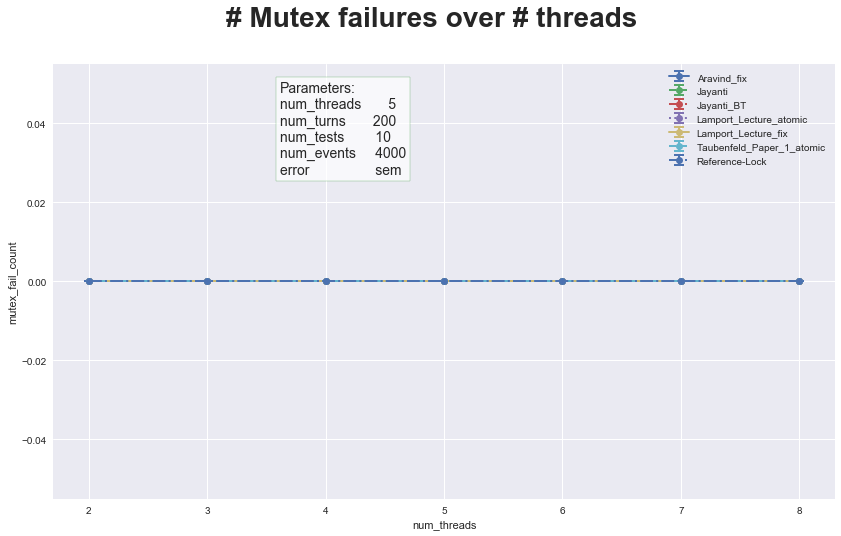

In [18]:
plot_col(df, x_col="num_threads", y_col="mutex_fail_count", title="# Mutex failures over # threads", norm=False)

# FCFS failures over nthreads

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


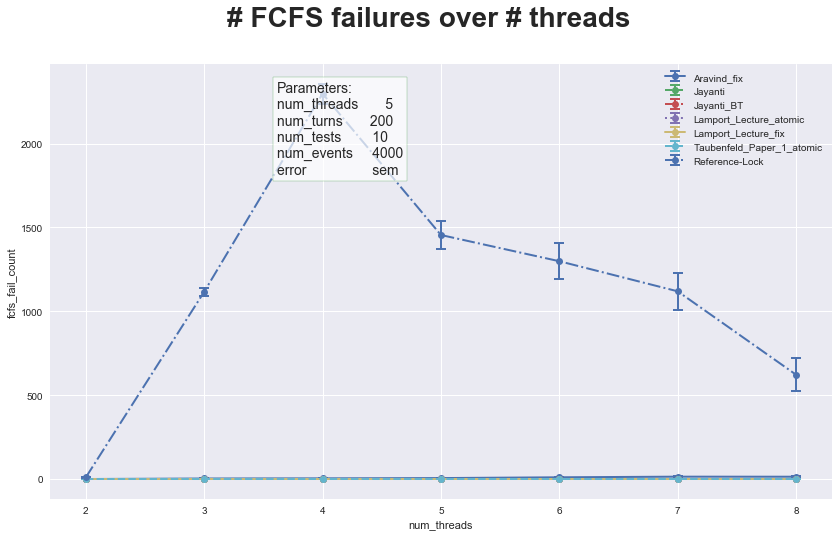

In [19]:
plot_col(df, x_col="num_threads", y_col="fcfs_fail_count", title="# FCFS failures over # threads", norm=False)
plt.savefig("plots/fcfs_fails.png")
plt.show()

# LRU failures over nthreads

In [20]:
all_locks
filtered = list(filter(lambda x: not any([x.find(l)>=0 for l in ["Reference-Lock", "Taubenfeld"]]), all_locks))
filtered

['Aravind',
 'Aravind_fix',
 'Jayanti',
 'Jayanti_BT',
 'Lamport_Lecture',
 'Lamport_Lecture_atomic',
 'Lamport_Lecture_fix',
 'Lamport_Original']

Plotting locks: ['Jayanti', 'Jayanti_BT']


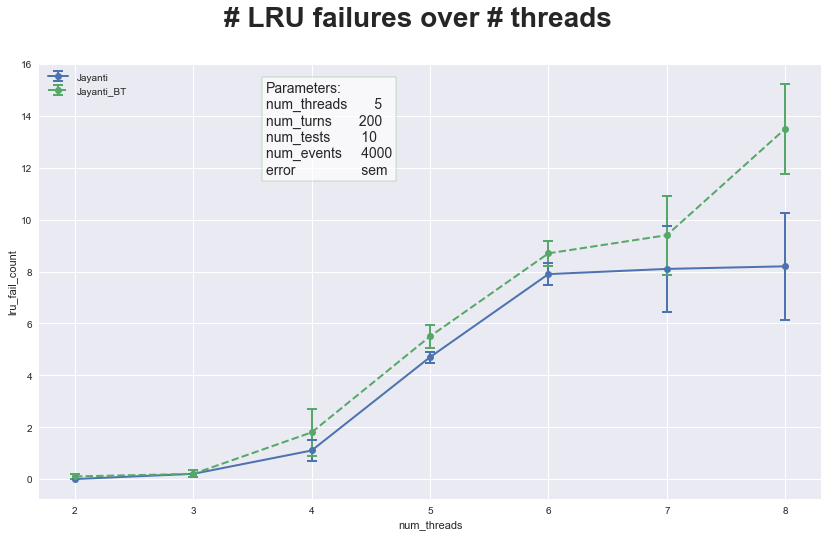

Plotting locks: ['Aravind', 'Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Lamport_Original']


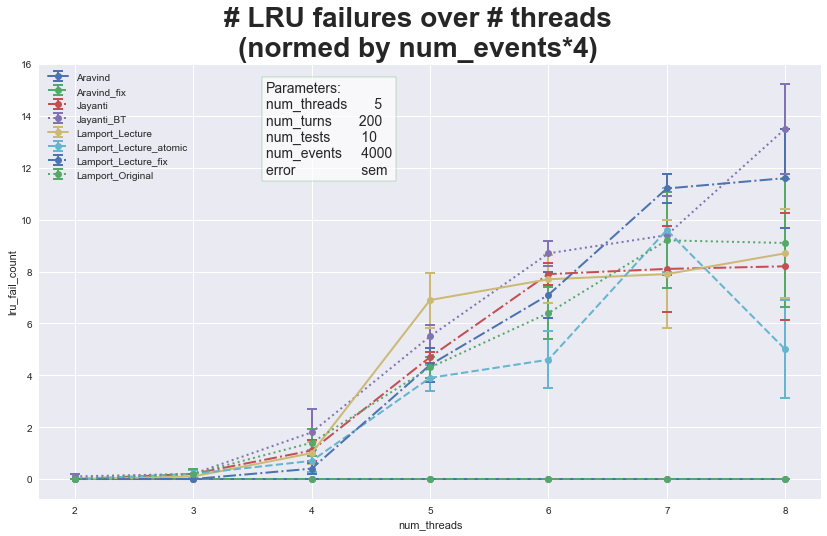

In [21]:
plot_col(df, x_col="num_threads", y_col="lru_fail_count", title="# LRU failures over # threads",\
         norm=False, locksToPlot="Jayanti") # Only plotting the Jayantis
plt.savefig("plots/lru_fails.png")
plt.show()
plot_col(df, x_col="num_threads", y_col="lru_fail_count", title="# LRU failures over # threads\n(normed by num_events*4)", 
         norm=False, locksToPlot=filtered)
plt.savefig("plots/lru_fails_normed.png")
plt.show()

In [22]:
result_cols

Index(['mutex_fail_count', 'fcfs_fail_count', 'lru_fail_count',
       'thp_runtime_wanc', 'thp_wanc', 'anc', 'thp_runtime_ref', 'thp_ref',
       'bm_runtime'],
      dtype='object')

# Runtime (of throughput test)

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


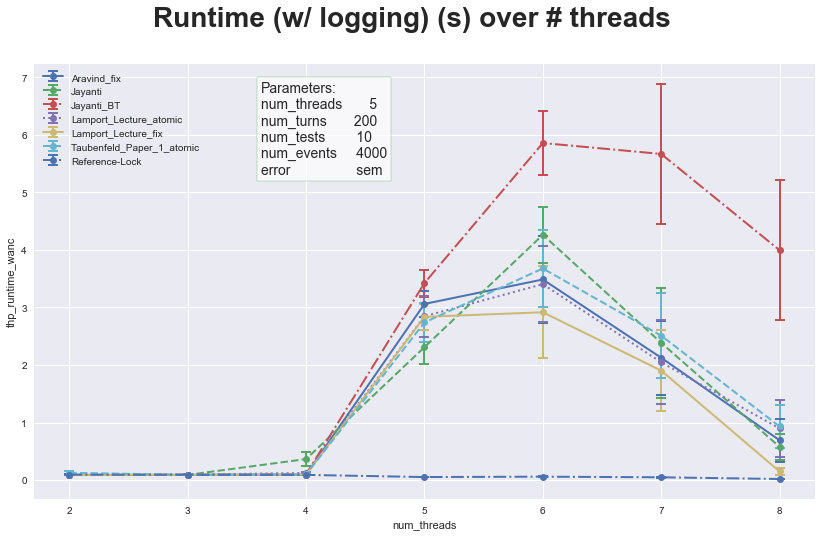

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


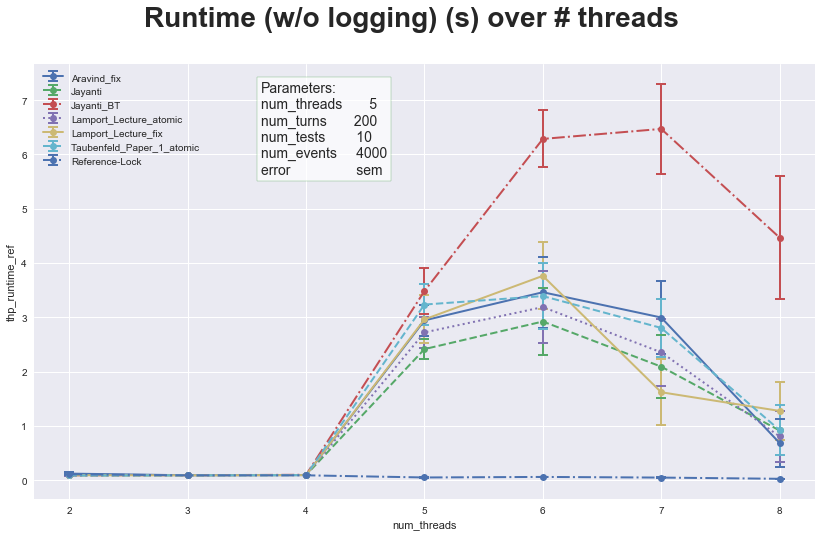

In [23]:
plot_col(df, x_col="num_threads", y_col="thp_runtime_wanc", title="Runtime (w/ logging) (s) over # threads", norm=False)
plt.savefig("plots/runtime.png")
plt.show()
plot_col(df, x_col="num_threads", y_col="thp_runtime_ref", title="Runtime (w/o logging) (s) over # threads", norm=False)
plt.savefig("plots/runtime_ref.png")
plt.show()

# Throughput

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


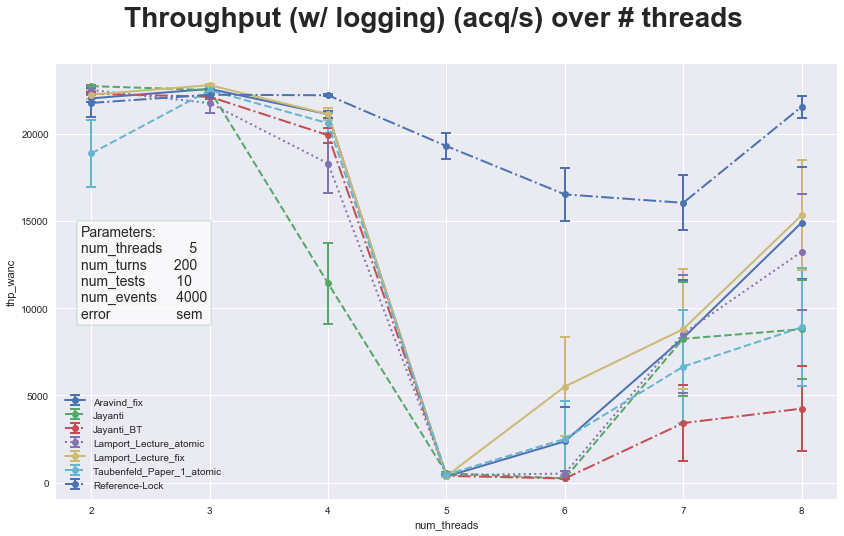

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


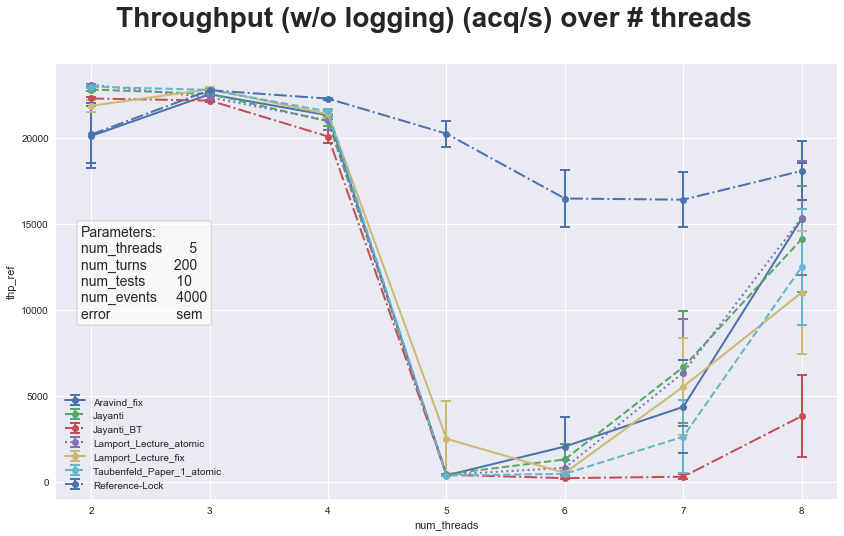

In [24]:
plot_col(df, x_col="num_threads", y_col="thp_wanc", title="Throughput (w/ logging) (acq/s) over # threads", norm=False, paramPos=(0.15, 0.6))
plt.savefig("plots/throughput.png")
plt.show()
plot_col(df, x_col="num_threads", y_col="thp_ref", title="Throughput (w/o logging) (acq/s) over # threads", norm=False, paramPos=(0.15, 0.6))
plt.savefig("plots/throughput_ref.png")
plt.show()

In [25]:
filtered2 = list(filter(lambda x: any([x.find(l)>=0 for l in ["fix", "atomic", "BT"]]), all_locks))
filtered2

['Aravind_fix',
 'Jayanti_BT',
 'Lamport_Lecture_atomic',
 'Lamport_Lecture_fix',
 'Taubenfeld_Paper_1_atomic']

In [26]:
all_locks

array(['Aravind', 'Aravind_fix', 'Jayanti', 'Jayanti_BT',
       'Lamport_Lecture', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix',
       'Lamport_Original', 'Reference-Lock', 'Taubenfeld_Paper_1',
       'Taubenfeld_Paper_1_Fix', 'Taubenfeld_Paper_1_atomic'],
      dtype=object)

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic']


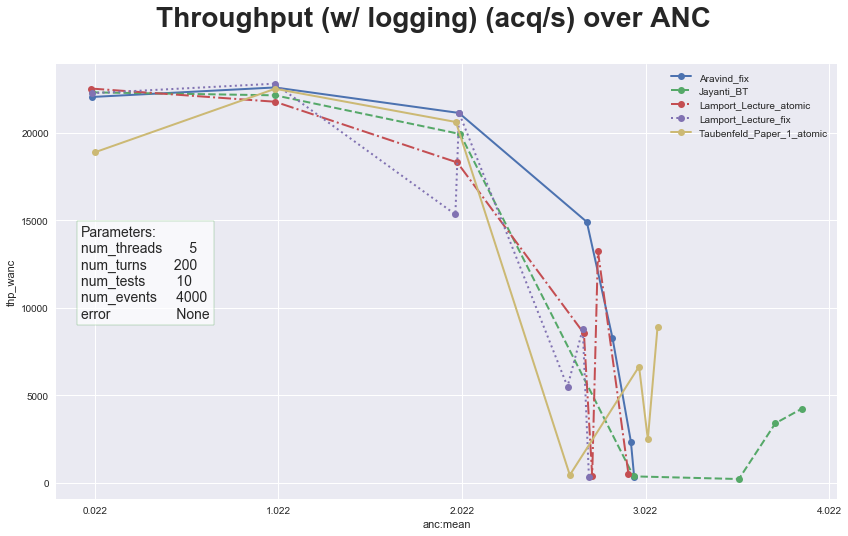

In [27]:
plot_col(df.sort_values(["lock_name", "anc:mean"]), x_col="anc:mean", y_col="thp_wanc", title="Throughput (w/ logging) (acq/s) over ANC", 
         norm=False, paramPos=(0.15, 0.6), locksToPlot=filtered2, errBarMode="None")
plt.savefig("plots/throughput_over_anc.png")
plt.show()

In [39]:
df.sort_values(["lock_name"]).info()
df.loc[5,"num_events"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 16 to 58
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   lock_name              84 non-null     object
 1   num_threads            84 non-null     object
 2   num_turns              84 non-null     object
 3   num_tests              84 non-null     object
 4   num_events             84 non-null     object
 5   mutex_fail_count:mean  84 non-null     object
 6   mutex_fail_count:std   84 non-null     object
 7   mutex_fail_count:min   84 non-null     object
 8   mutex_fail_count:max   84 non-null     object
 9   fcfs_fail_count:mean   84 non-null     object
 10  fcfs_fail_count:std    84 non-null     object
 11  fcfs_fail_count:min    84 non-null     object
 12  fcfs_fail_count:max    84 non-null     object
 13  lru_fail_count:mean    84 non-null     object
 14  lru_fail_count:std     84 non-null     object
 15  lru_fail_count:min     8

8000

Plotting locks: ['Aravind_fix', 'Jayanti', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Lamport_Lecture_fix', 'Taubenfeld_Paper_1_atomic', 'Reference-Lock']


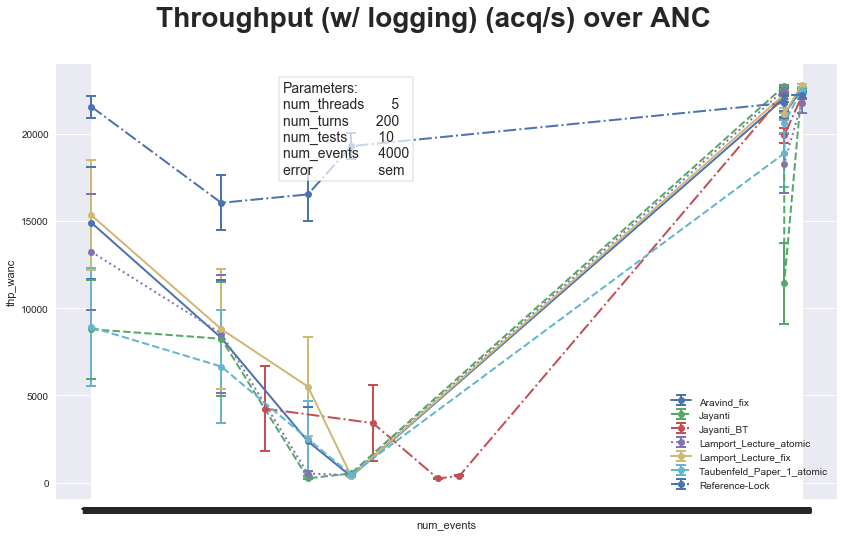

In [43]:
plot_col(df.sort_values(["lock_name", "num_events",]), x_col="num_events", y_col="thp_wanc", title="Throughput (w/ logging) (acq/s) over ANC")#, 
         #norm=False, paramPos=(0.15, 0.6), locksToPlot=filtered2)
#plt.savefig("plots/throughput_over_events.png")
#plt.show()

# Average number of contenders

In [ ]:
plot_col(df, x_col="num_threads", y_col="anc", title="# ANC over # threads", norm=False)
plt.savefig("plots/anc.png")
plt.show()

# Total Benchmark Runtime

In [ ]:
plot_col(df, x_col="num_threads", y_col="bm_runtime", title="BM Runtime over # threads", norm=False)
plt.savefig("plots/anc.png")
plt.show()